# CORDIC core

This notebook visualizes various results obtained from the CORDIC core in [```rtl/cordic.v```](../rtl/cordic.v) using the [```tb/core_test.sv```](../tb/core_test.sv) testbench

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt

---

## Helper functions

#### ```get_table_data(filename)``` 

Reads the log file with given filename and returns 5 numpy arrays :

| S.No  | Return array      | Array shape   | Description               |
|---    |:---:              |:---:          |---                        |
| 1     | ```idx_hist```    | ```size```    | Index                     |
| 2     | ```inp_hist```    | ```size, 3``` | Input variables           |
| 3     | ```exp_hist```    | ```size, 3``` | Expected output           |
| 4     | ```err_hist```    | ```size, 3``` | Actual - expected output  |
| 5     | ```sta_hist```    | ```size```    | True for OK, False for overflow |

#### ```separate(inp_list, sta_list)```

Separates or filters ```inp_list``` based on ```sta_list``` and returns 2 arrays

- ```good_list``` : ```inp_list``` items with 1 in ```sta_list``` at same index
- ```fail_list``` : ```inp_list``` items with 0 in ```sta_list``` at same index

#### ```vis_rot_inputs(inp_good, inp_fail, exp_good, exp_fail)```

Visualizes inputs for rotation mode. 3 plots are made

- Input x coordinate and y coordinate
- Expected x coordinate and y coordinate
- Input rotation angle and magnitude

In [2]:
def get_table_data(filename):
    with open(filename, "r") as f:
        table_found     = False
        summary_found   = False
        while(True):
            s = f.readline().strip()
            if(s == ''):
                break
            if(s == "Test table"):
                table_found = True
                break

        if(not table_found):
            return None
        
        f.readline()
        
        idx_hist = []
        inp_hist = []
        exp_hist = []
        err_hist = []
        sta_hist = []

        while(True):
            inp = f.readline().strip().split(':')
            if(inp[0][0] == '-'):
                break

            if(len(inp) != 3):
                return None

            dat = inp[1].split('|')

            if(len(dat) != 3):
                return None

            idx_hist.append(int(inp[0]))
            inp_hist.append(tuple(map(float, dat[0].split(','))))
            exp_hist.append(tuple(map(float, dat[1].split(','))))
            err_hist.append(tuple(map(float, dat[2].split(','))))
            sta_hist.append(True if inp[2].strip() == "OK" else False)
        
        return (np.asarray(idx_hist), np.asarray(inp_hist), np.asarray(exp_hist), np.asarray(err_hist), np.asarray(sta_hist))

In [3]:
def separate(inp_list, sta_list):
    good_list   = np.asarray([inp_list[i] for i in range(len(inp_list)) if sta_list[i]])
    fail_list   = np.asarray([inp_list[i] for i in range(len(inp_list)) if not sta_list[i]])
    return good_list, fail_list

In [4]:
def vis_rot_inputs(inp_good, inp_fail, exp_good, exp_fail):
    plt.figure(figsize=(30, 10), dpi=80)

    # Scatter plot for input coordintates
    plt.subplot(131)
    plt.scatter(inp_good[:, 0], inp_good[:, 1], s=5,  marker="o", c="green", label="Success")
    plt.scatter(inp_fail[:, 0], inp_fail[:, 1], s=10, marker="x", c="red",   label="Overflow")

    plt.xlabel("Input x coordinate")
    plt.ylabel("Input y coordinate")
    plt.title("Input coordinates")
    plt.legend()

    # Scatter plot for expected coordinates
    plt.subplot(132)
    plt.scatter(exp_good[:, 0], exp_good[:, 1], s=5,  marker="o", c="green", label="Success")
    plt.scatter(exp_fail[:, 0], exp_fail[:, 1], s=10, marker="x", c="red",   label="Overflow")

    plt.xlabel("Expected x coordinate")
    plt.ylabel("Expected y coordinate")
    plt.title("Expected output coordinates")
    plt.legend()

    # Scatter plot for input coordinate magnitude and input rotation angle
    plt.subplot(133)
    plt.scatter(inp_good[:, 2], np.linalg.norm(inp_good[:, 0:2], axis=1), s=5,  marker="o", c="green", label="Success")
    plt.scatter(inp_fail[:, 2], np.linalg.norm(inp_fail[:, 0:2], axis=1), s=10, marker="x", c="red",   label="Overflow")

    plt.xlabel("Input angle")
    plt.ylabel("Input coordinate magnitude")
    plt.title("Input rotation angle and input coordinate magnitude")
    plt.legend()


    plt.show()

In [135]:
def vis_rot_error(inp_ls, exp_ls, err_ls):

    x_err_dB   = 20 * np.log10(np.abs(err_ls[:, 0] / exp_ls[:, 0]))
    y_err_dB   = 20 * np.log10(np.abs(err_ls[:, 1] / exp_ls[:, 1]))
    ang_err_dB = 20 * np.log10(np.maximum(1e-10, np.abs(err_ls[:, 2])) / 180)
    mag_err_dB = 20 * np.log10(np.linalg.norm(err_ls[:, 0:2], axis=1) / np.linalg.norm(exp_ls[:, 0:2], axis=1))

    plt.figure(figsize=(30, 10), dpi=80)
    
    # Input angle v/s magnitude error
    plt.subplot(131)
    plt.scatter(inp_ls[:, 2], ang_err_dB, s=5)
    plt.ylim((-250, 0))
    plt.xlabel("Input angle (degrees)")
    plt.ylabel("Angle residual (dB)")
    plt.title("Input angle v/s angle residual")
        
    # Input angle v/s angle residual
    plt.subplot(132)
    plt.scatter(x_err_dB, y_err_dB, s=5)
    plt.axis('square')
    plt.xlabel("x error (dB)")
    plt.ylabel("y error (dB)")
    plt.title("X error v/s y error")

    plt.subplot(133)
    plt.hist(mag_err_dB, density = True, bins=30, histtype='step', label="Magnitude error")
    plt.hist(ang_err_dB, density = True, bins=30, histtype='step', label="Angle error")
    plt.xlim((-250, 0))
    plt.xlabel("Error (dB)")
    plt.ylabel("Density")
    plt.legend()
    plt.title("Error histogram")

    plt.show()

In [136]:
def vis_rot_inputs_file(filename):
    idx_ls, inp_ls, exp_ls, err_ls, sta_ls = get_table_data(filename)
    idx_good, idx_fail = separate(idx_ls, sta_ls)
    inp_good, inp_fail = separate(inp_ls, sta_ls)
    exp_good, exp_fail = separate(exp_ls, sta_ls)
    err_good, err_fail = separate(err_ls, sta_ls)

    vis_rot_inputs(inp_good, inp_fail, exp_good, exp_fail)

def vis_rot_error_file(filename):
    idx_ls, inp_ls, exp_ls, err_ls, sta_ls = get_table_data(filename)
    idx_good, idx_fail = separate(idx_ls, sta_ls)
    inp_good, inp_fail = separate(inp_ls, sta_ls)
    exp_good, exp_fail = separate(exp_ls, sta_ls)
    err_good, err_fail = separate(err_ls, sta_ls)

    vis_rot_error(inp_good, exp_good, err_good)

def vis_rotation_file(filename):
    idx_ls, inp_ls, exp_ls, err_ls, sta_ls = get_table_data(filename)
    idx_good, idx_fail = separate(idx_ls, sta_ls)
    inp_good, inp_fail = separate(inp_ls, sta_ls)
    exp_good, exp_fail = separate(exp_ls, sta_ls)
    err_good, err_fail = separate(err_ls, sta_ls)

    vis_rot_inputs(inp_good, inp_fail, exp_good, exp_fail)
    vis_rot_error(inp_good, exp_good, err_good)

---

# Rotation mode inputs

Look at the following plots to analyze coverage and overflow cases for rotation mode

Circular mode


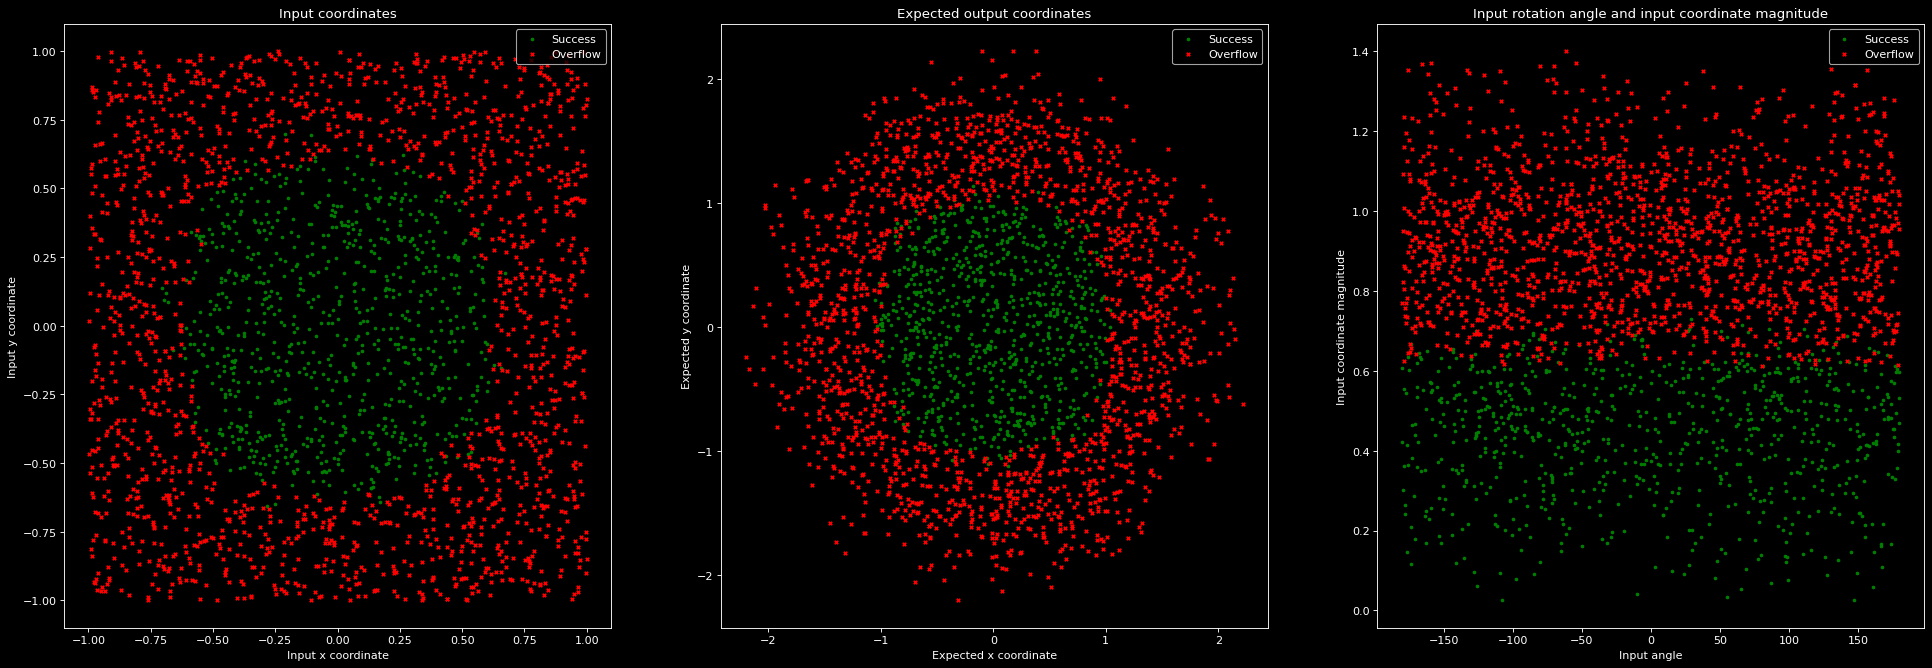

Hyperbolic mode


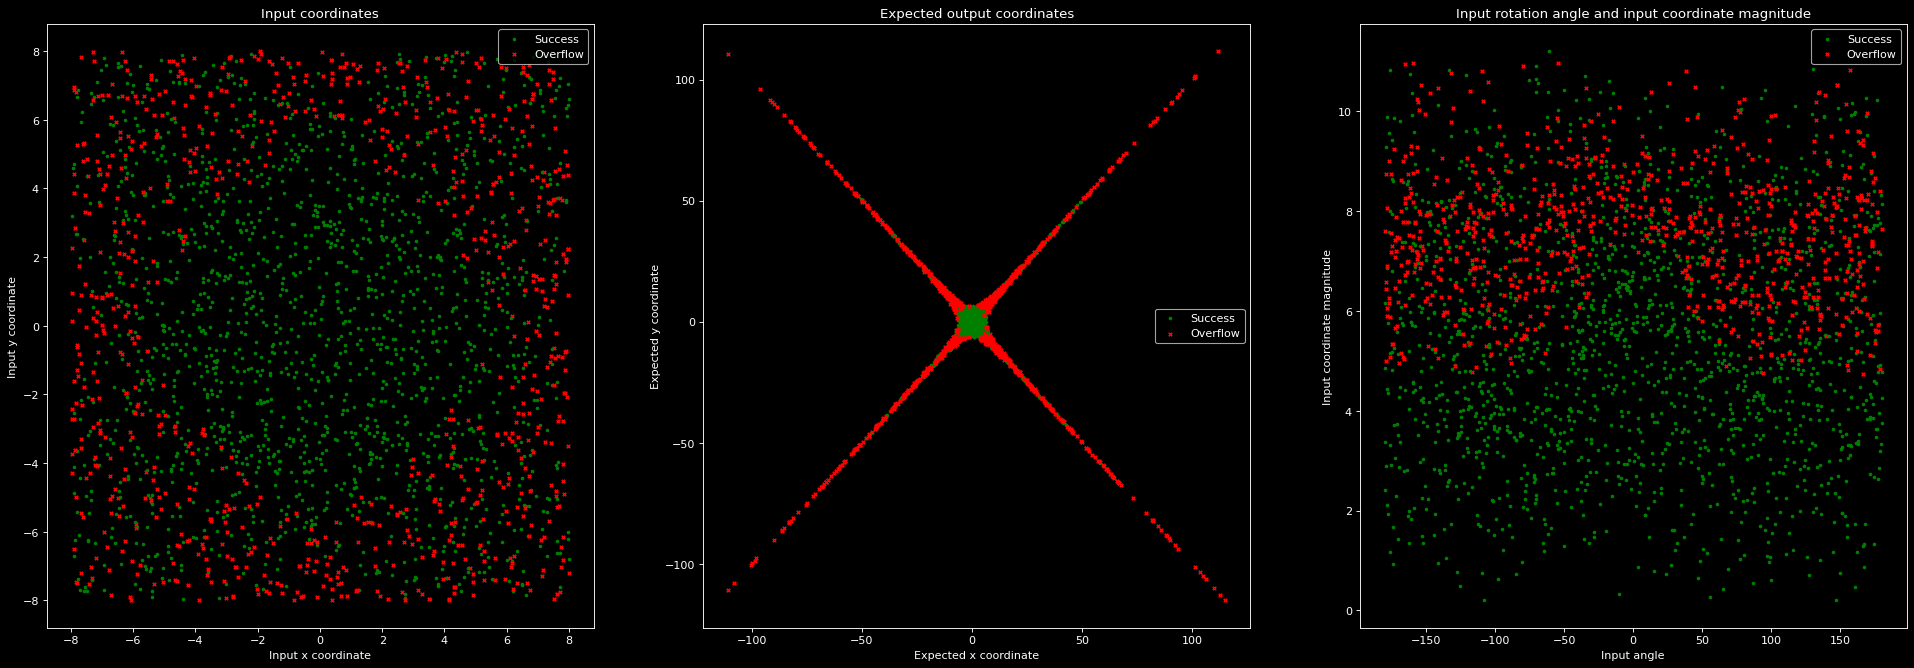

In [137]:
# View inputs for full (including inputs that will lead to out of bounds outputs)
print("Circular mode")
vis_rot_inputs_file("data/circ_rot/cr_30_off_off_x2500_full.txt")

print("Hyperbolic mode")
vis_rot_inputs_file("data/hyp_rot/hr_30_off_off_x2500_full.txt")

Circular mode


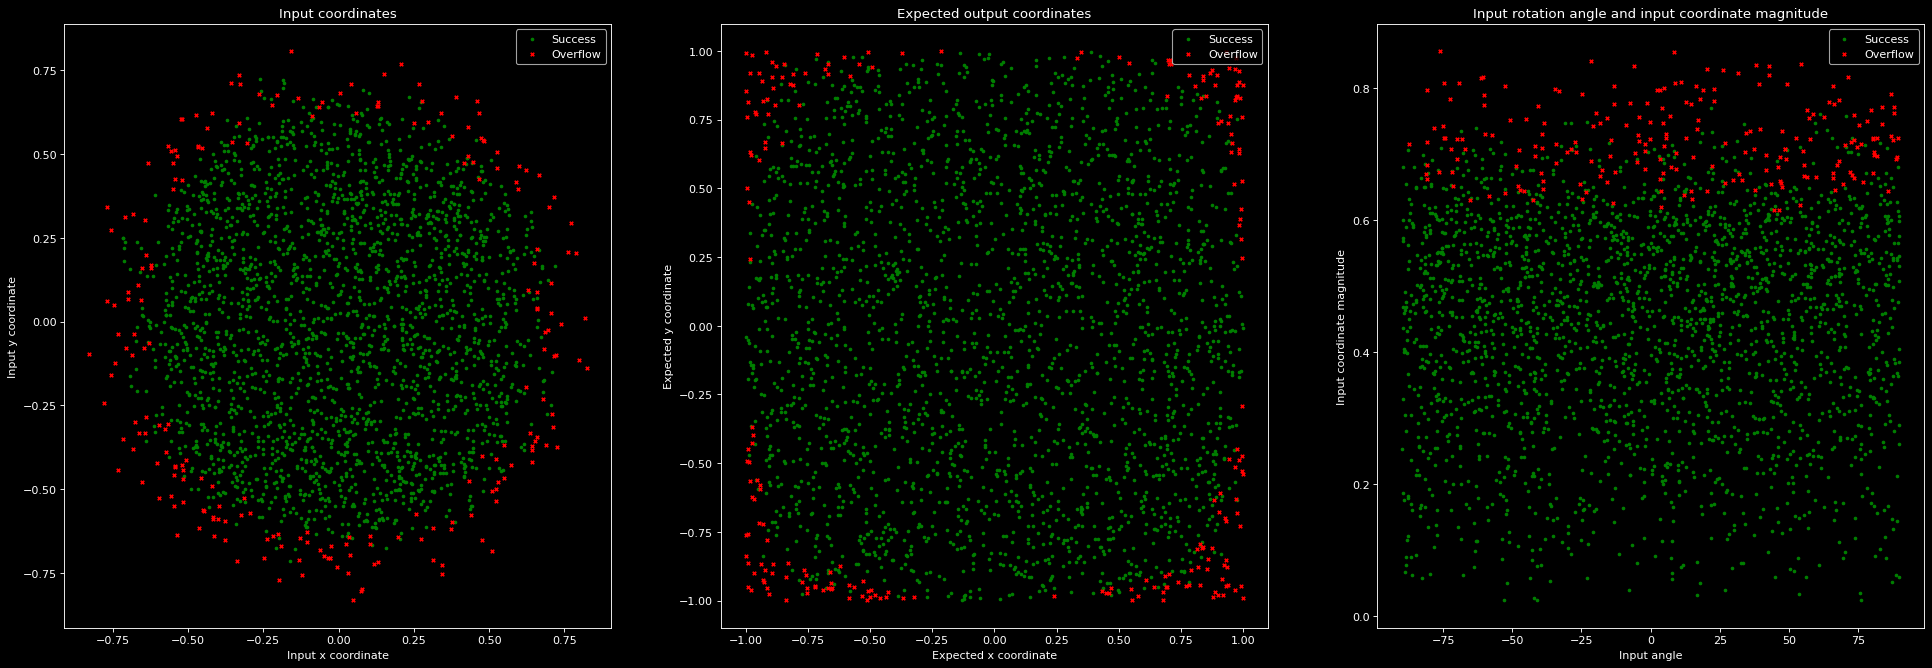

Hyperbolic mode


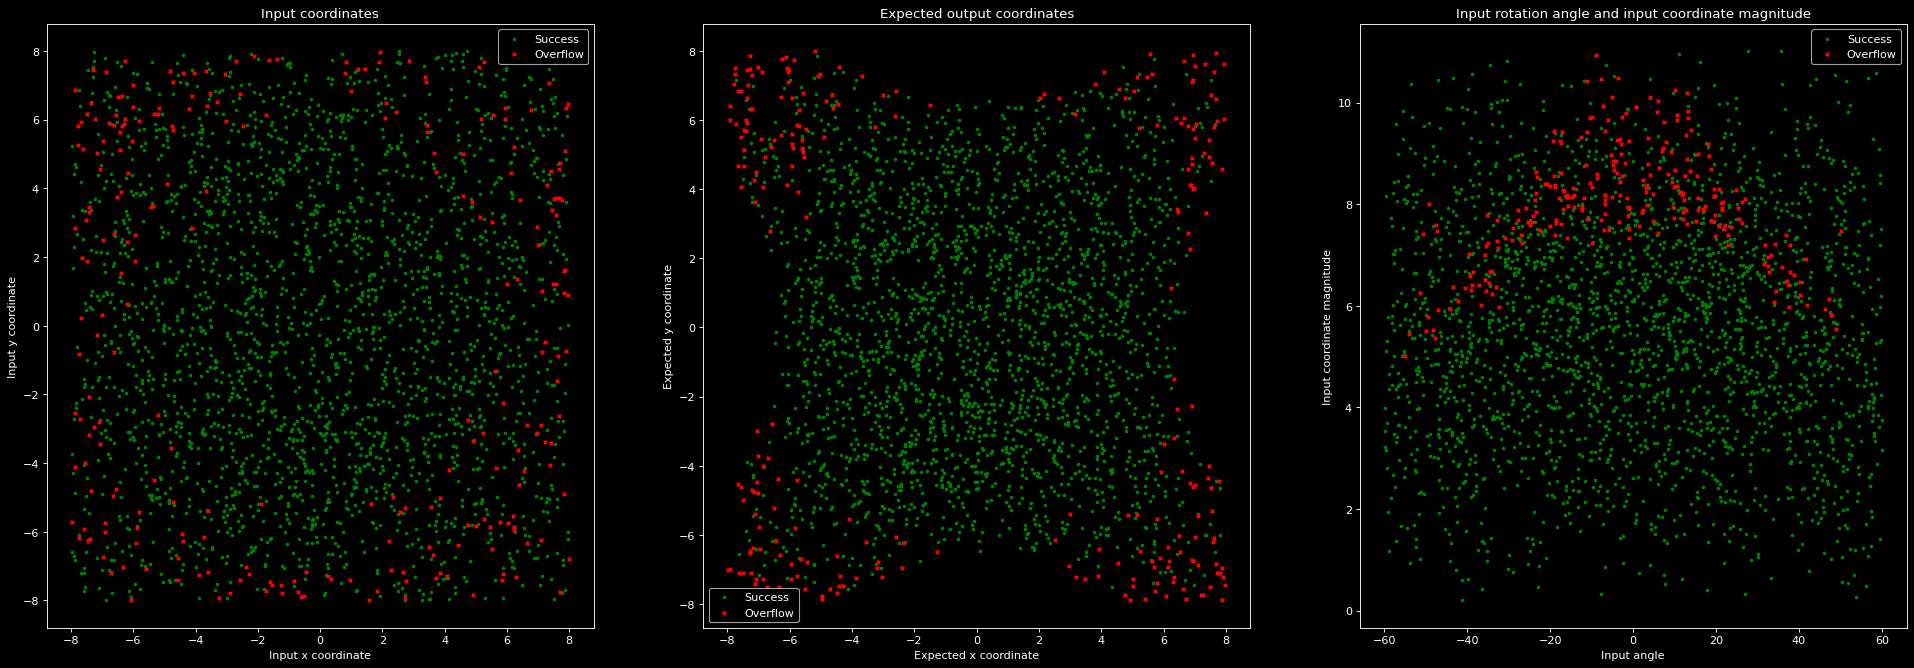

In [138]:
# View inputs without including those that will lead to out-of-bounds
print("Circular mode")
vis_rot_inputs_file("data/circ_rot/cr_30_off_off_x2500.txt")

print("Hyperbolic mode")
vis_rot_inputs_file("data/hyp_rot/hr_30_off_off_x2500.txt")

10 CORDIC iterations


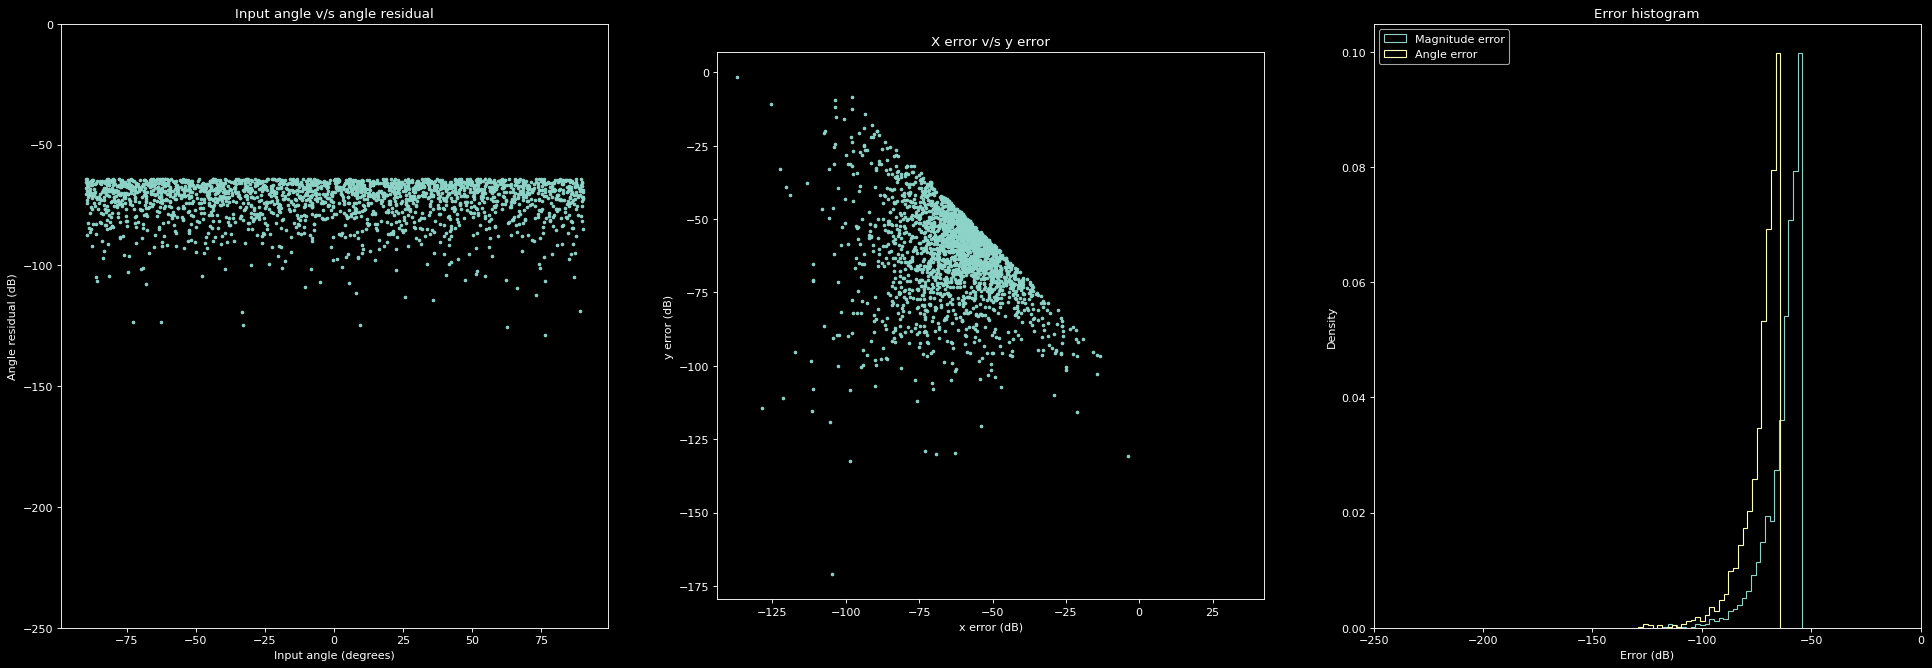

15 CORDIC iterations


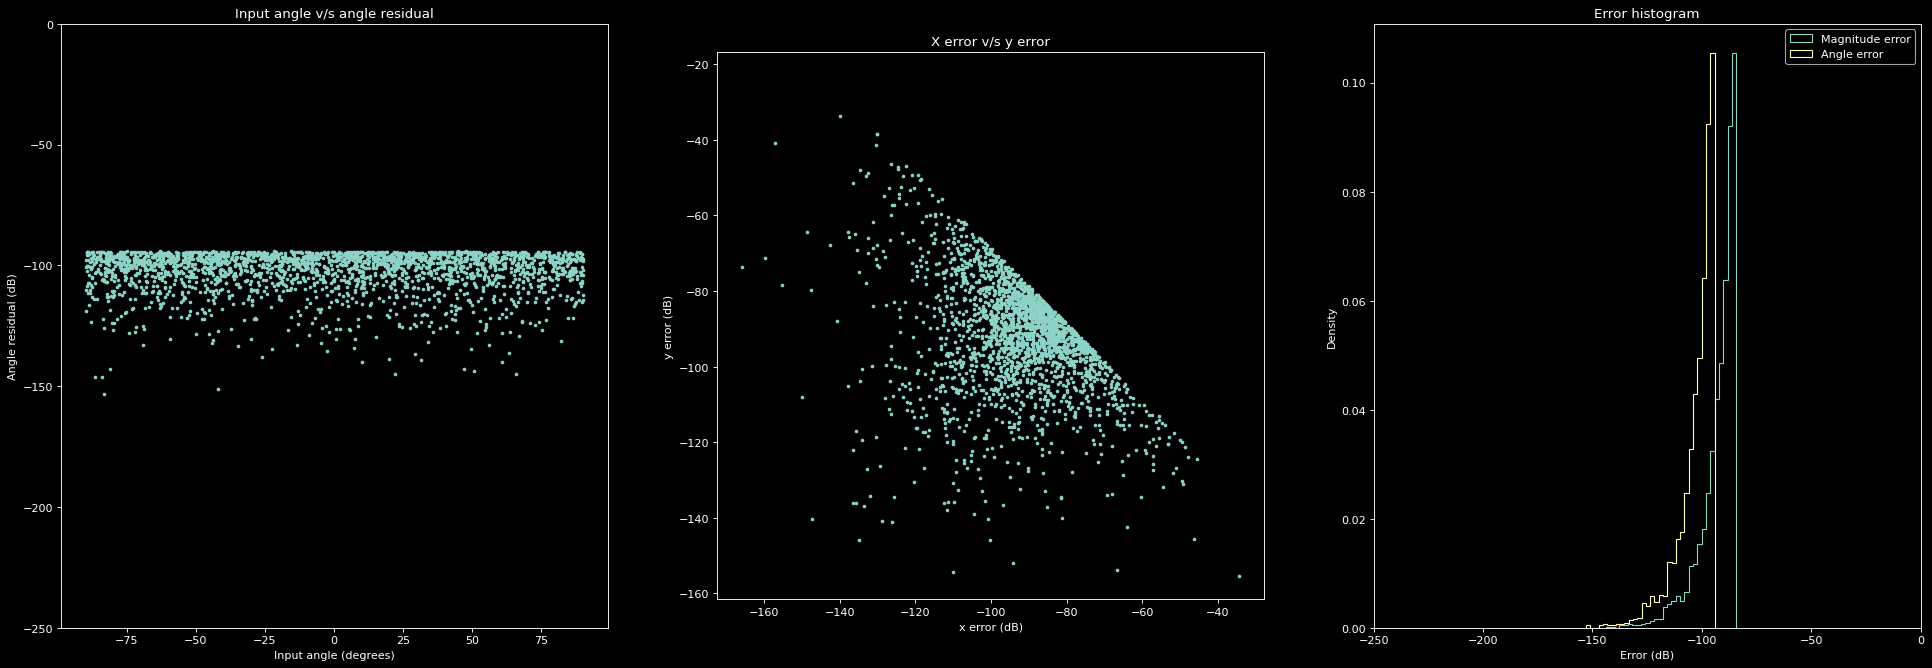

20 CORDIC iterations


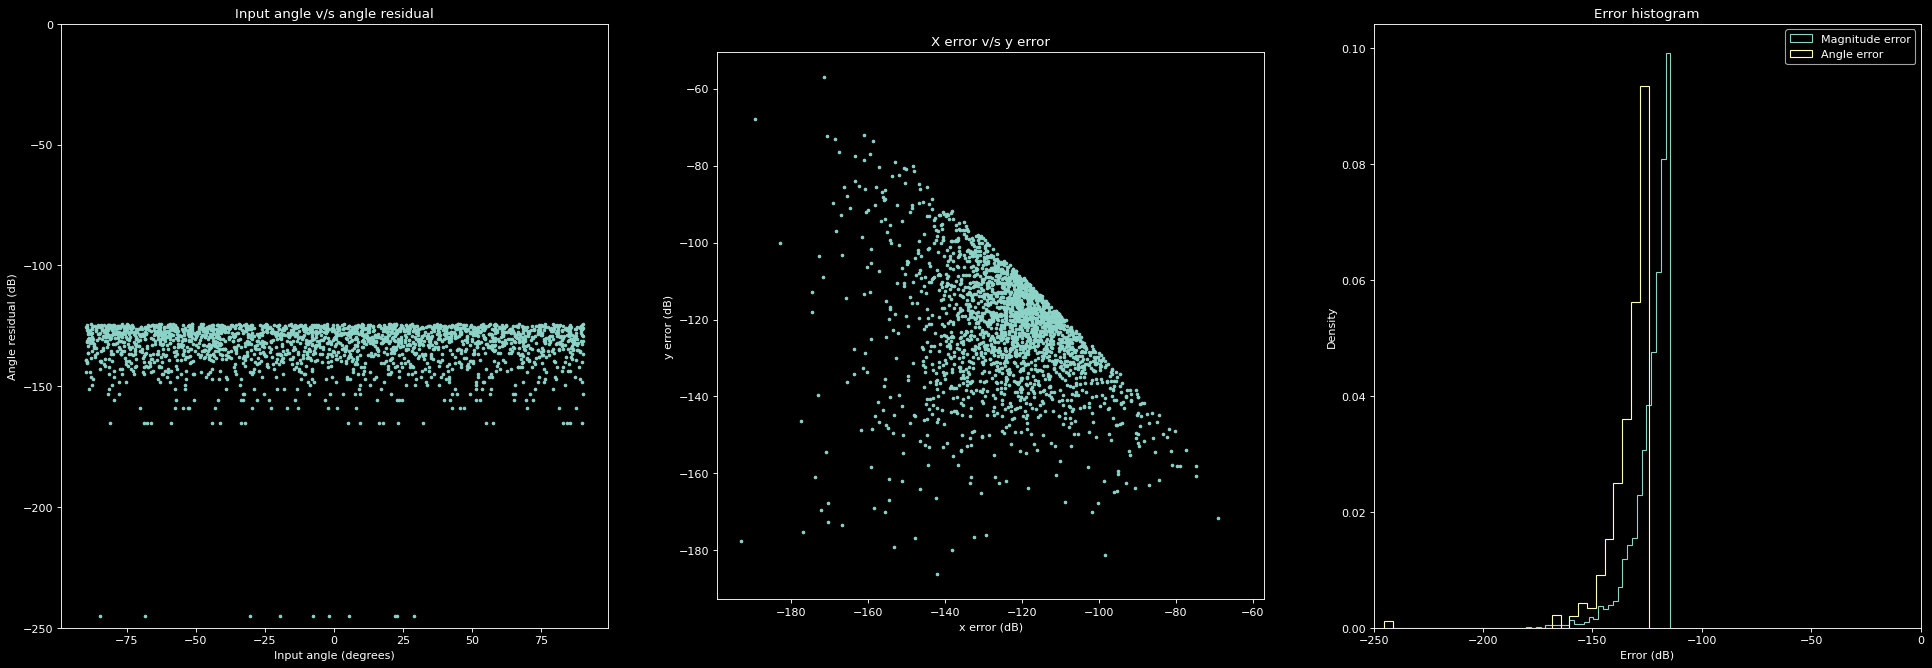

25 CORDIC iterations


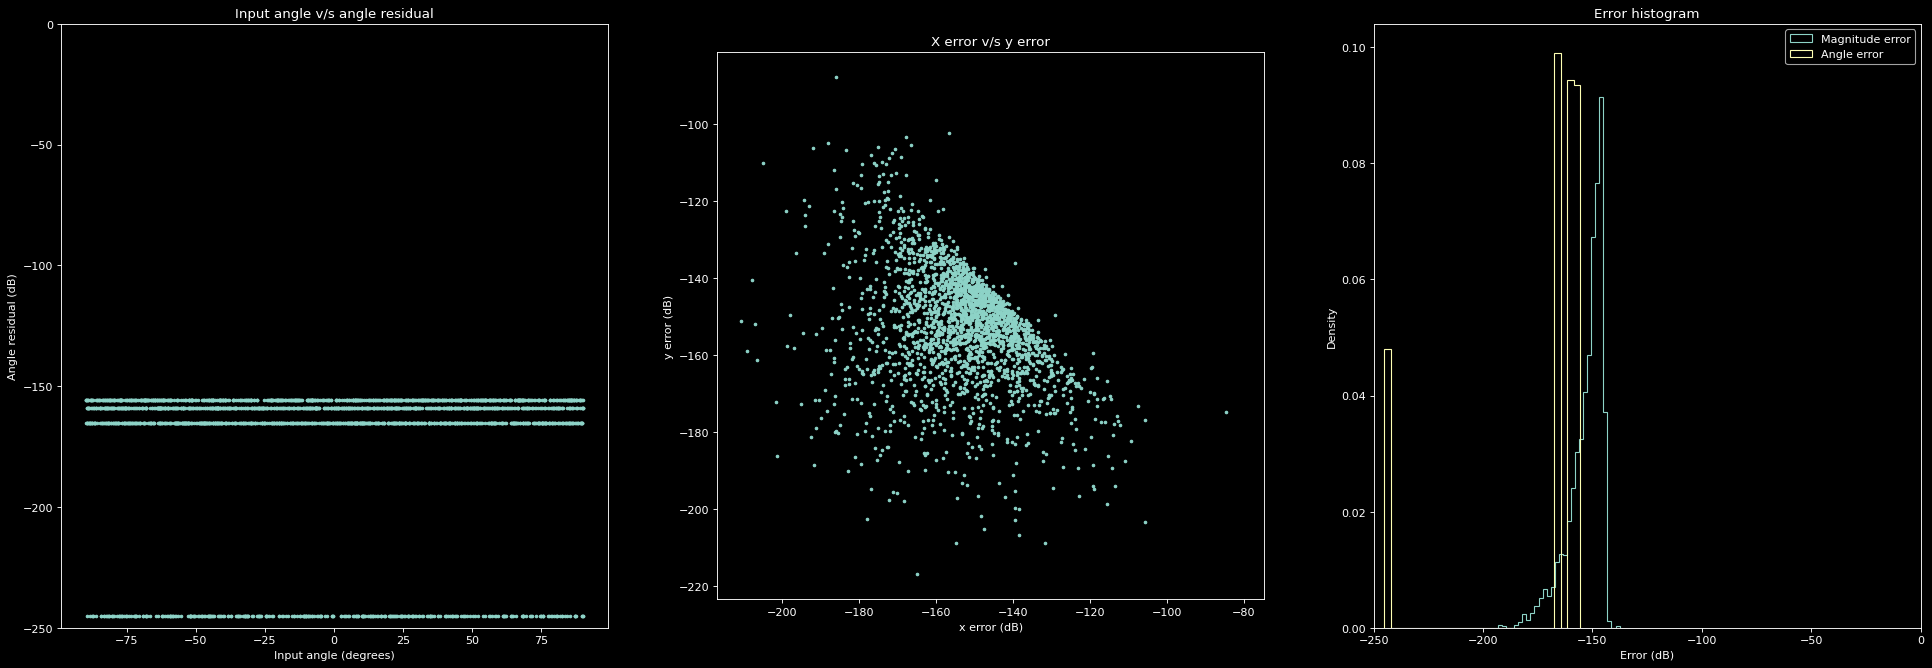

30 CORDIC iterations


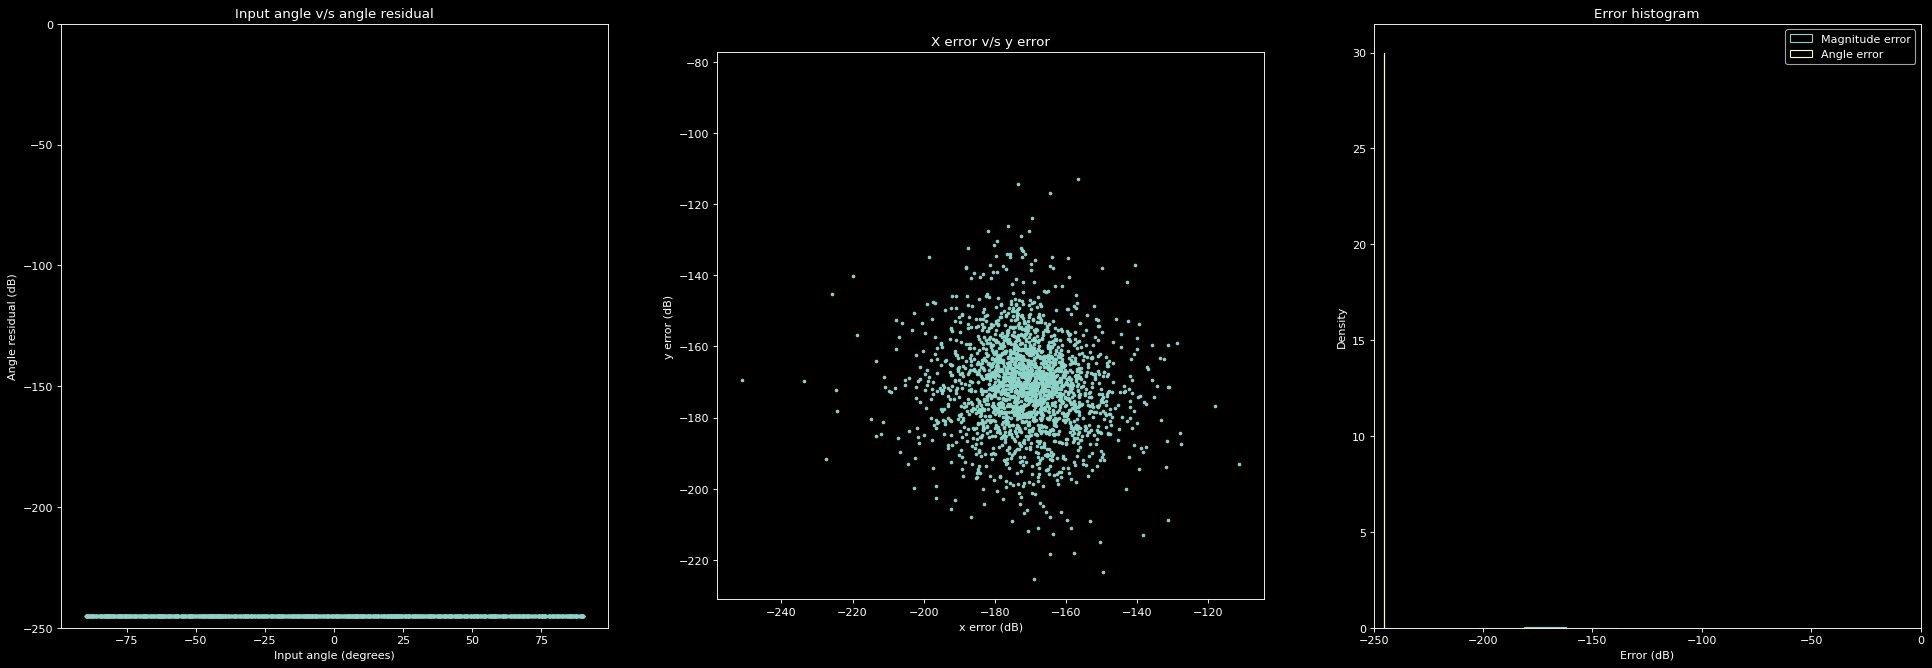

In [139]:
# Error for circular mode with different number of iterations
for i in (10, 15, 20, 25, 30):
    print("%d CORDIC iterations"%(i))
    vis_rot_error_file("data/circ_rot/cr_%d_off_off_x2500.txt"%(i))

10 CORDIC iterations


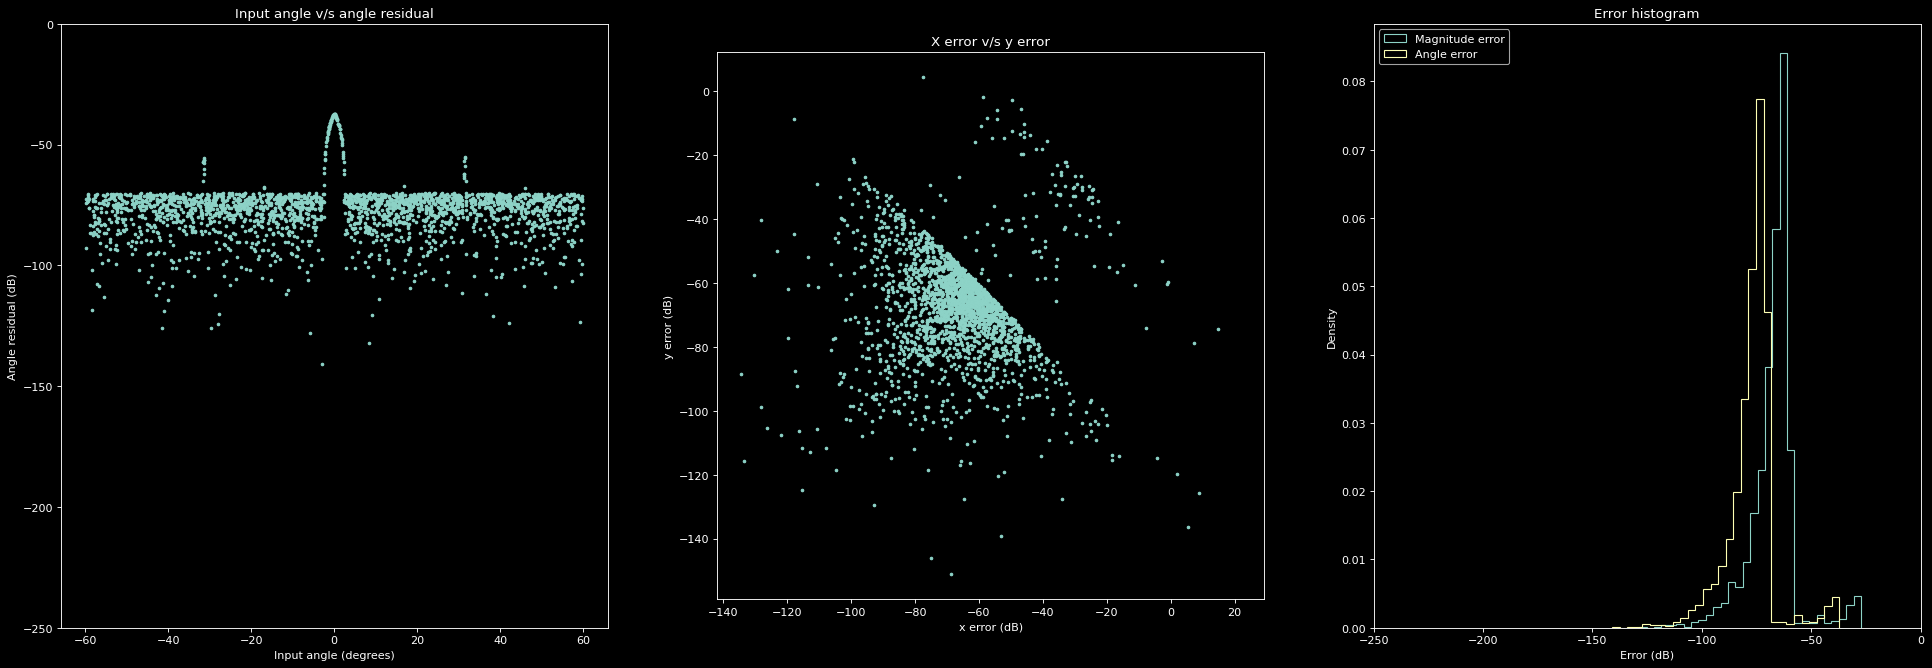

15 CORDIC iterations


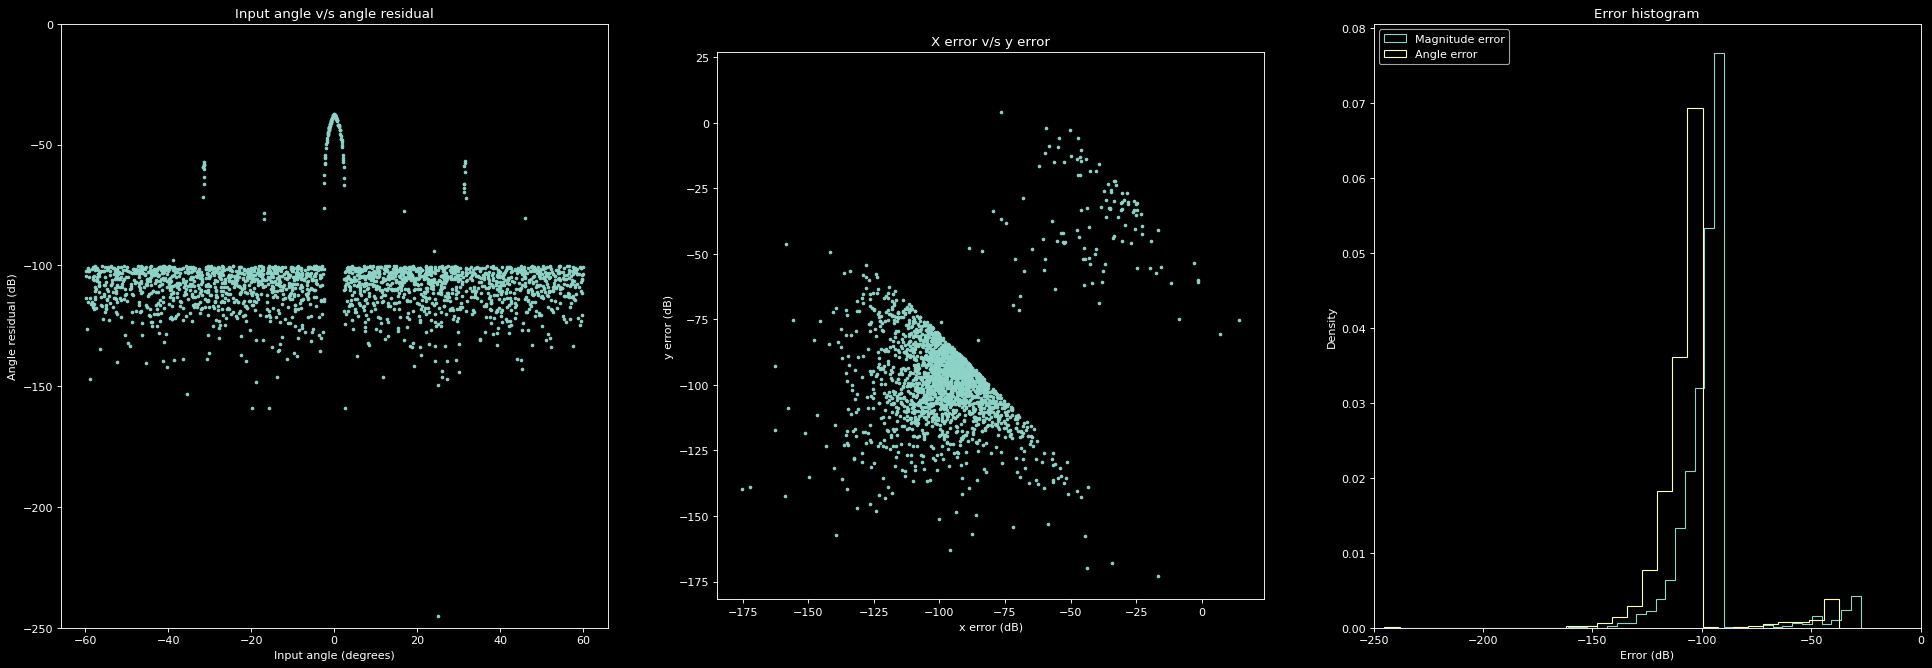

20 CORDIC iterations


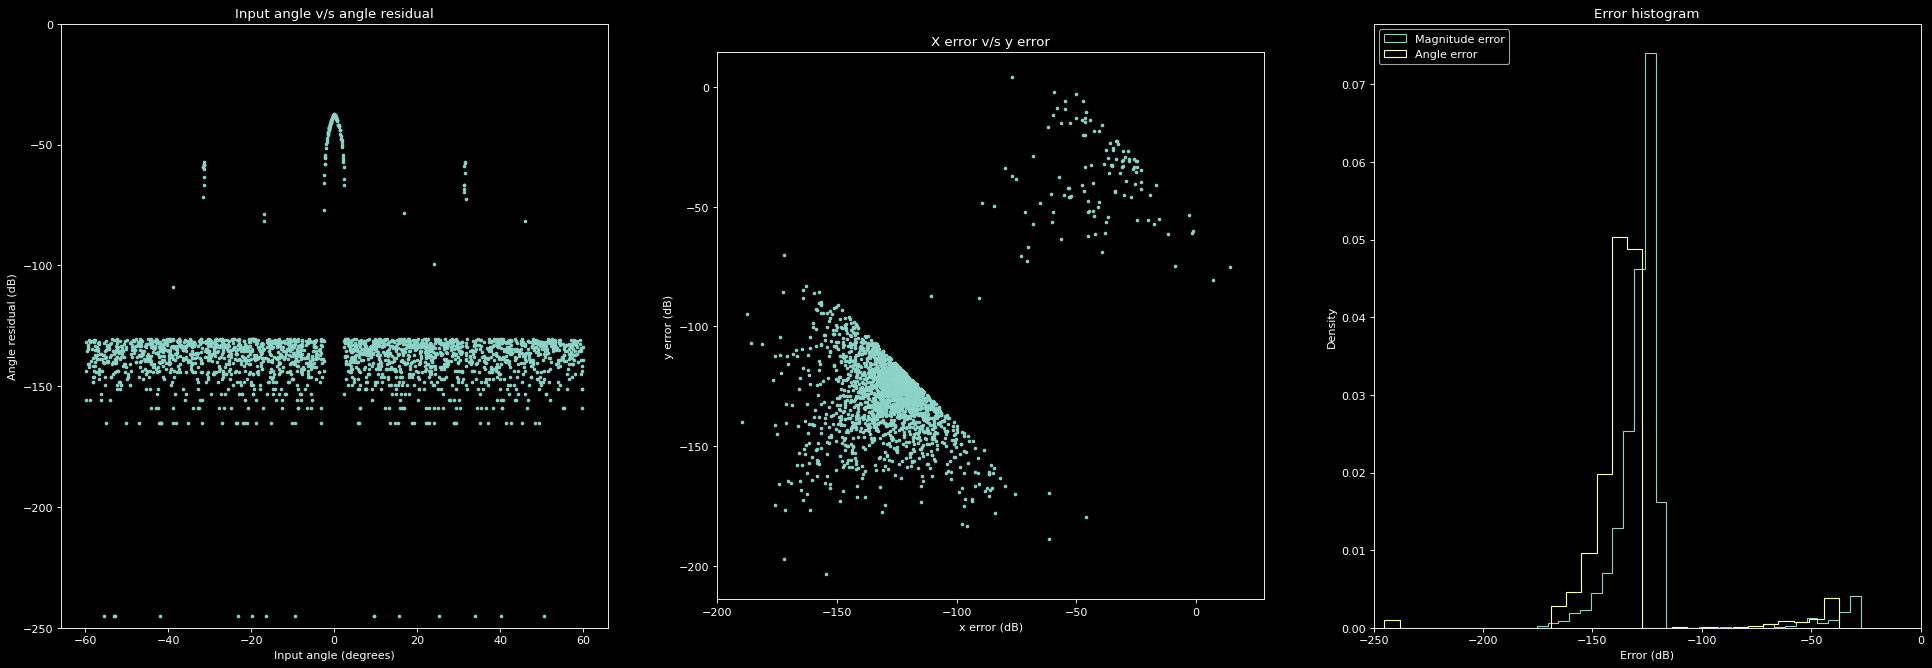

25 CORDIC iterations


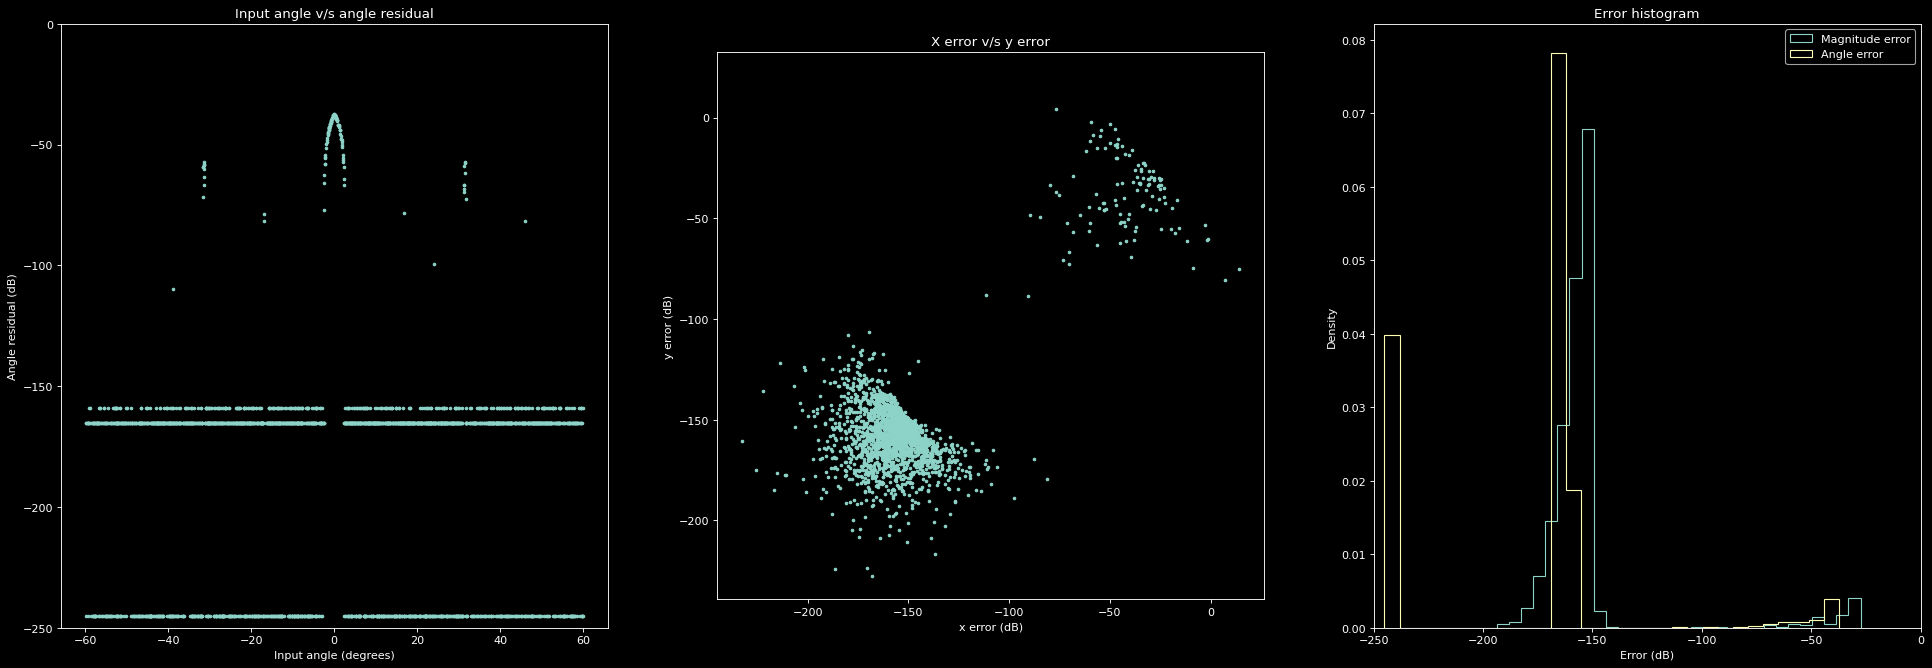

30 CORDIC iterations


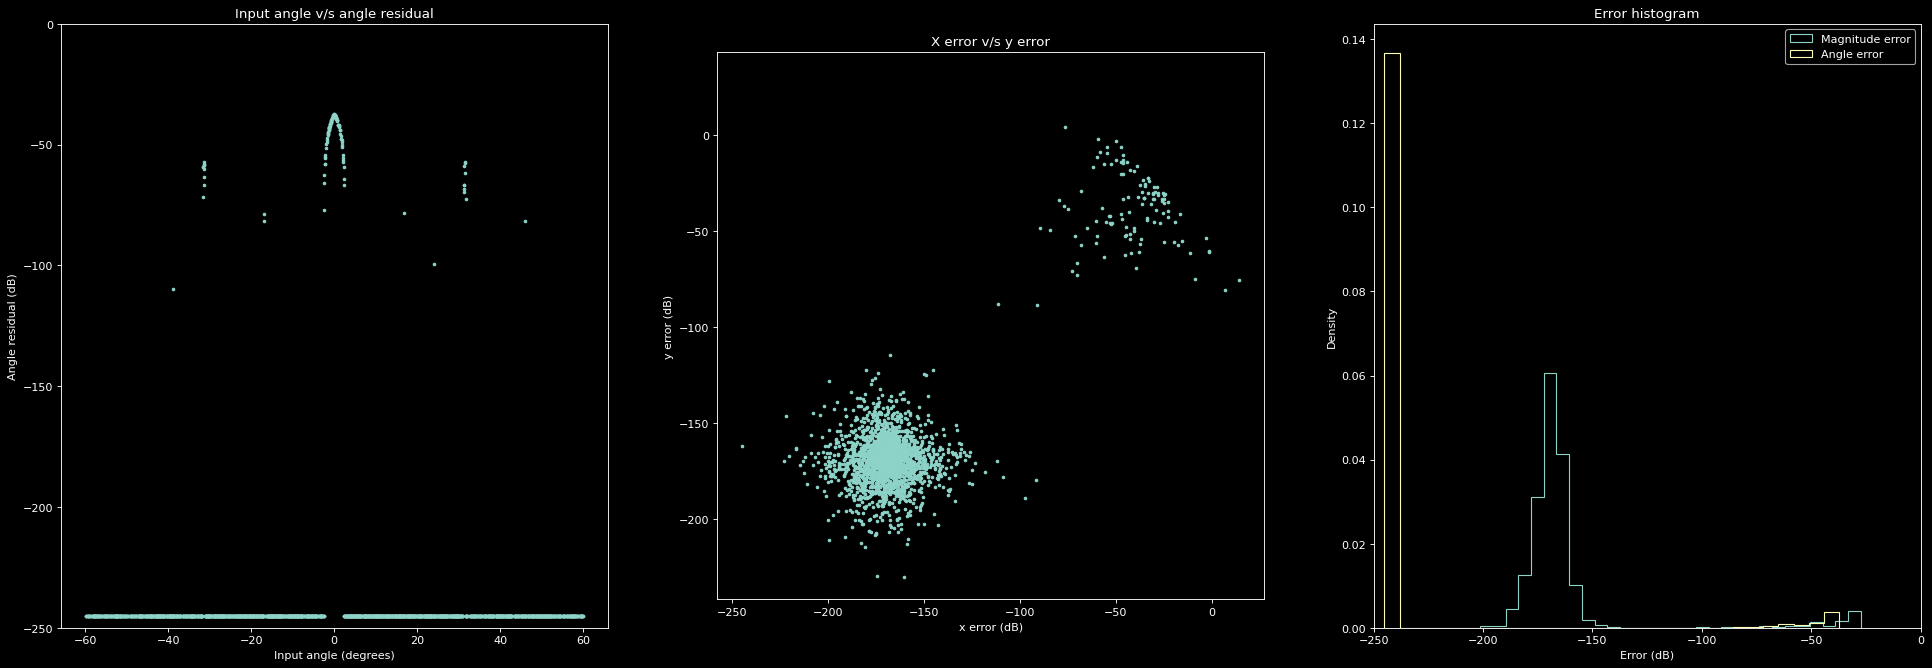

In [140]:
# Error for hyperbolic mode with different number of iterations
for i in (10, 15, 20, 25, 30):
    print("%d CORDIC iterations"%(i))
    vis_rot_error_file("data/hyp_rot/hr_%d_off_off_x2500.txt"%(i))